## Set up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
pd.reset_option('all')

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/2267882860.py:7: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


### Import and observe raw data

- author_flair_text: flair is a category functionality that the platform allows for users to categorize their posts
- score: number of upvotes minus number of downvotes


In [2]:
submissions_raw = pd.read_csv("data/raw_submissions.csv")
submissions_raw

,id,created,author,author_flair_text,title,selftext,score,num_comments,link
0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,Tips for being successful in the workplace (as...,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...
1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,"If you are using Google Chrome, start typing t...",NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...
2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,"When applying eyedrops, don't drop them inside...",NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...
3,fs4uz,2011-02-24 16:55,u/someprimetime,NaN,Here is how you eat a chicken wing,NaN,30,5,https://www.reddit.com/r/LifeProTips/comments/...
4,fs4pu,2011-02-24 16:49,u/someprimetime,NaN,Use GMAIL as a to-do list,Setup a simple TODO list in Gmail:\n\nClick on...,2,2,https://www.reddit.com/r/LifeProTips/comments/...
...,...,...,...,...,...,...,...,...,...
751022,18vk2gg,2023-12-31 17:38,u/DrugOfGods,NaN,LPT: use a fitted sheet to transport inflated ...,"Can fit a few dozen balloons, and easy to carry.",679,46,https://www.reddit.com/r/LifeProTips/comments/...
751023,18vk4gc,2023-12-31 17:41,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...
751024,18vk8z1,2023-12-31 17:48,u/n1cutesmile,NaN,"LTP:If you have a dog, please please PLEASE ge...",[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...
751025,18vk9oa,2023-12-31 17:49,u/n1cutesmile,NaN,LTP:Is Pet Insurance - Worth it or No?,[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...


## Data Preprocessing

### Remove missing values

In [3]:
def remove_missing_data(raw_df, column):
    '''
    Filters all entries that have [removed] or [deleted] in their body/self 
    text column (as applicable). Also filters NaN values.
    
    Input: 
        - raw_df: Pandas dataframe
        - column: Target column to look for missing values
    
    Returns:
        - Cleaned dataframe
    '''

    print("DataFrame shape before cleaning:", raw_df.shape)

    #Remove rows with values of "[removed]" or "[deleted]" 
    to_filter = ["[removed]", "[deleted]", "\[deleted\]"]
    mask = ~raw_df[column].isin(to_filter)
    filtered_df = raw_df[mask]

    print("DataFrame shape after filtering removed values:", 
                                                 filtered_df.shape)
    
    #Filter NaN
    filtered_df = filtered_df.dropna(subset=[column])
    print("DataFrame shape after filtering NaN values:", filtered_df.shape)

    return filtered_df

In [4]:
submissions_filtered1 = remove_missing_data(submissions_raw, "title")
submissions_filtered1

DataFrame shape before cleaning: (751027, 9)
DataFrame shape after filtering removed values: (751027, 9)
DataFrame shape after filtering NaN values: (751023, 9)


,id,created,author,author_flair_text,title,selftext,score,num_comments,link
0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,Tips for being successful in the workplace (as...,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...
1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,"If you are using Google Chrome, start typing t...",NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...
2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,"When applying eyedrops, don't drop them inside...",NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...
3,fs4uz,2011-02-24 16:55,u/someprimetime,NaN,Here is how you eat a chicken wing,NaN,30,5,https://www.reddit.com/r/LifeProTips/comments/...
4,fs4pu,2011-02-24 16:49,u/someprimetime,NaN,Use GMAIL as a to-do list,Setup a simple TODO list in Gmail:\n\nClick on...,2,2,https://www.reddit.com/r/LifeProTips/comments/...
...,...,...,...,...,...,...,...,...,...
751022,18vk2gg,2023-12-31 17:38,u/DrugOfGods,NaN,LPT: use a fitted sheet to transport inflated ...,"Can fit a few dozen balloons, and easy to carry.",679,46,https://www.reddit.com/r/LifeProTips/comments/...
751023,18vk4gc,2023-12-31 17:41,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...
751024,18vk8z1,2023-12-31 17:48,u/n1cutesmile,NaN,"LTP:If you have a dog, please please PLEASE ge...",[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...
751025,18vk9oa,2023-12-31 17:49,u/n1cutesmile,NaN,LTP:Is Pet Insurance - Worth it or No?,[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...


### Remove duplicates

In [5]:
#Remove duplicates based on the title column because some people post the same 
#2+ times and they would still have different ids and times of creation
submissions_filtered2 = submissions_filtered1.drop_duplicates(subset=['title'])

print("DataFrame shape before removing duplicates:", submissions_filtered1.shape)
print("DataFrame shape after removing duplicates:", submissions_filtered2.shape)

DataFrame shape before removing duplicates: (751023, 9)
DataFrame shape after removing duplicates: (719063, 9)


### Clean text

In [6]:
#https://www.w3schools.com/python/ref_string_translate.asp
#https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string

def clean_text(s):
    '''
    Cleans text
    
        Inputs:
            - s (string)
            
        Returns:
            - cleaned string
    '''

    #Remove links
    text = re.sub(r'http\S+|www\S+', '', s)

    #Removes punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    #Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Remove line breaks
    text = text.replace('\n', ' ').replace('\r', ' ')

    #Lowercase
    text = text.lower()

    #Remove unnecesary whitespace
    return text.strip()

#Apply function to title
submissions_filtered2["cleaned_title"] = submissions_filtered2["title"].apply(lambda x: clean_text(x))

#Apply function to selftext with try/except logic because they could be empty (the poster only wrote in the title)
try:    
    submissions_filtered2["cleaned_bodytext"] = submissions_filtered2["selftext"].apply(lambda x: clean_text(x))
except:
    submissions_filtered2["cleaned_bodytext"] = ""  


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/3007311107.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2["cleaned_title"] = submissions_filtered2["title"].apply(lambda x: clean_text(x))
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/3007311107.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2["cleaned_bodytext"] = ""


### Concatenate title and body text

In [7]:
# Concatenating title and body columns while handling NaN values
submissions_filtered2['title+bodytext'] = submissions_filtered2['cleaned_title']\
        .fillna('') + " " + submissions_filtered2['cleaned_bodytext'].fillna('')

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/2387432504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2['title+bodytext'] = submissions_filtered2['cleaned_title']\


In [8]:
submissions_filtered2

,id,created,author,author_flair_text,title,selftext,score,num_comments,link,cleaned_title,cleaned_bodytext,title+bodytext
0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,Tips for being successful in the workplace (as...,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...,tips for being successful in the workplace as ...,,tips for being successful in the workplace as ...
1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,"If you are using Google Chrome, start typing t...",NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...,if you are using google chrome start typing th...,,if you are using google chrome start typing th...
2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,"When applying eyedrops, don't drop them inside...",NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...,when applying eyedrops dont drop them inside t...,,when applying eyedrops dont drop them inside t...
3,fs4uz,2011-02-24 16:55,u/someprimetime,NaN,Here is how you eat a chicken wing,NaN,30,5,https://www.reddit.com/r/LifeProTips/comments/...,here is how you eat a chicken wing,,here is how you eat a chicken wing
4,fs4pu,2011-02-24 16:49,u/someprimetime,NaN,Use GMAIL as a to-do list,Setup a simple TODO list in Gmail:\n\nClick on...,2,2,https://www.reddit.com/r/LifeProTips/comments/...,use gmail as a todo list,,use gmail as a todo list
...,...,...,...,...,...,...,...,...,...,...,...,...
751022,18vk2gg,2023-12-31 17:38,u/DrugOfGods,NaN,LPT: use a fitted sheet to transport inflated ...,"Can fit a few dozen balloons, and easy to carry.",679,46,https://www.reddit.com/r/LifeProTips/comments/...,lpt use a fitted sheet to transport inflated b...,,lpt use a fitted sheet to transport inflated b...
751023,18vk4gc,2023-12-31 17:41,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...,lptplease learn from a ton of terrible mistake...,,lptplease learn from a ton of terrible mistake...
751024,18vk8z1,2023-12-31 17:48,u/n1cutesmile,NaN,"LTP:If you have a dog, please please PLEASE ge...",[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...,ltpif you have a dog please please please get ...,,ltpif you have a dog please please please get ...
751025,18vk9oa,2023-12-31 17:49,u/n1cutesmile,NaN,LTP:Is Pet Insurance - Worth it or No?,[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...,ltpis pet insurance worth it or no,,ltpis pet insurance worth it or no


### Delete very short texts

In [17]:
#Create column with word count
submissions_filtered2['word_count'] = submissions_filtered2['title+bodytext'].apply(lambda x: len(x.split()))

#Delete very short texts
print("Submissions shape before dropping short texts:", submissions_filtered2.shape)
submissions_filtered3 = submissions_filtered2[submissions_filtered2.word_count >= 10]
print("Submissions shape after dropping short texts:", submissions_filtered3.shape)

Submissions shape before dropping short texts: (719063, 13)
Submissions shape after dropping short texts: (566301, 13)


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/1245643967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered2['word_count'] = submissions_filtered2['title+bodytext'].apply(lambda x: len(x.split()))


### Sentiment analysis - part of preprocessing because at this stage it is only to use it as a helper for identifying spam/odd posts (that could have very high values of positivity/negativiy)

In this part, sentiment analysis will be done to observe outlier values that could be signs of spam

In [20]:
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def analyzeSentiment(text):
    # Get sentiment scores (positive, neutral, negative, compound)
    score = sid.polarity_scores(text)
    return score

#Apply function to the dataset
submissions_filtered3['vader_score'] = submissions_filtered3['title+bodytext'].apply(analyzeSentiment)
#Divide result into the 4 categories
submissions_filtered3[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = submissions_filtered3['vader_score'].apply(pd.Series)


/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/3272460920.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered3['vader_score'] = submissions_filtered3['title+bodytext'].apply(analyzeSentiment)
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/3272460920.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submissions_filtered3[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = submissions_filtered3['vader_score'].apply(pd.Series)
/var/folders/5q/

Check distributions of emotional scores

In [21]:
submissions_filtered3['vader_neg'].quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])

0.00    0.000
0.10    0.000
0.25    0.000
0.50    0.000
0.75    0.104
0.90    0.181
1.00    0.752
Name: vader_neg, dtype: float64

In [12]:
submissions_filtered3['vader_pos'].quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])

0.00    0.000
0.10    0.000
0.25    0.000
0.50    0.083
0.75    0.147
0.90    0.221
1.00    0.692
Name: vader_pos, dtype: float64

Sort by values to see if there's any odd submission. Look at the first 50 for both positive and negative emotion values

In [13]:
with pd.option_context('display.max_colwidth', None):
    display(submissions_filtered3.sort_values(by='vader_pos', ascending=False)[["vader_pos","title+bodytext", "id"]].head(50))

,vader_pos,title+bodytext,id
290200,0.692,to be the best of the best at something a tutor is a huge boost to success a helping hand,6sq2mc
223859,0.669,i love this happy holidays merrychristmas happychanukah sharpharmade holiday fit follow like celebrate enjoy wp tweet buffer tagsforlike share pop blog linkinbio lpt ig insta awesome santa gift present instagram sharpharmade,5k9ysy
541297,0.669,lpt interested in working from home and gaining time freedom financial freedom friendships opportunities and all around better life improvements,ij7x53
422199,0.630,lpt your friend doesnt need to consider you their best friend in order for you to consider them your best friend its perfectly fine to have a best friend who thinks youre a good friend,bl7vfp
120661,0.628,good morning special sms greetings wallpaper jokes images pictures and many more read how to earn 100 daily free free free free,3dt25b
399665,0.623,lpt people love free things and a smile costs nothing you lose nothing spending one and can gain respect admirability or opportunities with them,ah08sg
180819,0.616,from least to greatest intelligence knowledge wisdom love all humans are capable of love no matter what their capacity is,4pfjm2
357650,0.616,this is my very good friend joes dream and creation along with his awesome team so so happy to share this,8uwjqj
226604,0.610,be sure to reward your housekeeper gardener or other hired help with small incentives like a christmas bonus or free lunch,5luzm3
240285,0.609,happy valentines day happyvalentinesday valentine wp buffer lpt linkinbio fit tagsforlikes sharpharmade blog blogger follow like celebrate enjoy love instagram sharpharmade,5u0klm


In [23]:
with pd.option_context('display.max_colwidth', None):
    display(submissions_filtered3.sort_values(by='vader_neg', ascending=False)[["vader_neg","title+bodytext", "id"]].head(50))

,vader_neg,title+bodytext,id
596500,0.752,a dumb person cant play smart but a smart person can play dumb,m81wao
234604,0.732,suffer the pain of discipline or suffer the pain of regret,5qtjhc
592663,0.725,learn to differentiate bullies by haters with jealous enviers haters mentally hate jealous physically hates,ltypn2
503219,0.725,if youre sad pissed annoyed angry do a press up,g91d0s
475018,0.715,lpt scream i have aids stop when getting raped to scare the rapist,enfkmg
61582,0.703,lpt killing relationships violence incites retaliatory violence lets stop violence and practice prudence,26cw0u
234606,0.701,ltp suffer the pain of discipline or suffer the pain of regret,5qtksi
472223,0.699,lpt will i be fired or suffer serious reputational damage,eiba60
503220,0.688,lpt if youre sad pissed annoyed angry do a press up,g91ds0
265722,0.678,rotten eggs negative people can be very difficult and depressing,6a4rtx


Store ids of odd posts in a list to remove

In [25]:
irrelevant_pos = ["5k9ysy", "3dt25b", "8uwjqj", "5u0klm", "5jhedo", "2nhjwh", 
              "5tbrpo", "8dczqj", "2h0zym", "pyn07p", "57f63p", "5qx2vt"]

irrelevant_neg = ["8exxzv", "o2u5yl", "37j69u", "2by04x"]

to_remove = irrelevant_pos + irrelevant_neg

Function to remove rows with the given values

In [28]:
def filters_df(input_df, column, to_remove):
    '''
    Filters DataFrame based on given values

    Input:
        - input_df
        - column: column to search given values
        - to_remove (list): values to remove

    Output: 
        Filtered df
    '''

    mask = ~input_df[column].isin(to_remove)
    filtered_df = input_df[mask]

    #Check for deleted rows

    num_rows_before = input_df.shape[0]
    num_rows_after = filtered_df.shape[0]

    print("{} rows deleted. {} rows left".format((num_rows_before - num_rows_after), num_rows_after) )
    
    return filtered_df

#Apply function to data
cleaned_submissions = filters_df(submissions_filtered3, "id", to_remove)

16 rows deleted. 566285 rows left


### Get year and month data

In [29]:
#Create function to extract year and month of publication
def extract_time(date_string):
    '''
    Extracts year and month of publication from the "created column
    
    Input:
        - date_string: date and hour of publication
        
    Returns:
        (tuple): year and date of publication'''
    date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M")

    return date_object.year, date_object.month

#Apply function to the dataframe to create year and month columns
cleaned_submissions[['year', 'month']] = cleaned_submissions['created'].apply\
                                           (lambda x: pd.Series(extract_time(x)))

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/634848451.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_submissions[['year', 'month']] = cleaned_submissions['created'].apply\
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1343/634848451.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_submissions[['year', 'month']] = cleaned_submissions['created'].apply\


## Exploratory Data Analysis (cleaned data)

### Average lenght of texts

Average number of words: 23.51350821582772


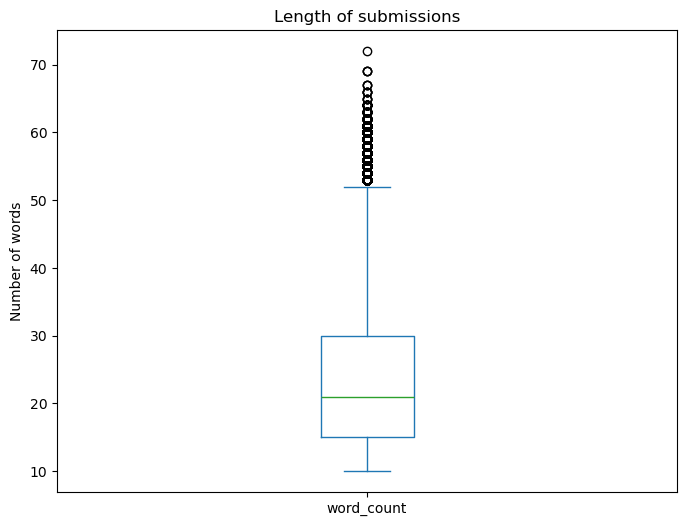

In [30]:
# Average submissions
average_length_submissions = cleaned_submissions['word_count'].mean()
print(f"Average number of words: {average_length_submissions}")

# Create a boxplot of the word counts
plt.figure(figsize=(8, 6))
cleaned_submissions["word_count"].plot(kind='box')
plt.title('Length of submissions')
plt.ylabel('Number of words')
plt.show()

### Observe distribution of volume of publications throughout the years

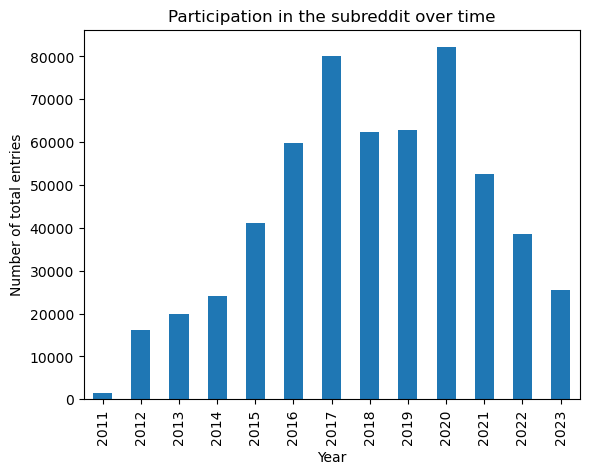

In [32]:
year_counts = cleaned_submissions['year'].value_counts().sort_index()

year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of total entries')
plt.title('Participation in the subreddit over time')
plt.show()

### Observe number of participants in the forum

In [33]:
authors = cleaned_submissions["author"]
print("{} unique authors".format(len(set(authors))))


240259 unique authors


## Export final df

In [36]:
cleaned_submissions.shape

(566285, 20)

In [34]:
cleaned_submissions

,id,created,author,author_flair_text,title,selftext,score,num_comments,link,cleaned_title,cleaned_bodytext,title+bodytext,word_count,vader_score,vader_neg,vader_neu,vader_pos,vader_compound,year,month
0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,Tips for being successful in the workplace (as...,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...,tips for being successful in the workplace as ...,,tips for being successful in the workplace as ...,14,"{'neg': 0.0, 'neu': 0.67, 'pos': 0.33, 'compou...",0.000,0.670,0.330,0.7096,2011,2
1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,"If you are using Google Chrome, start typing t...",NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...,if you are using google chrome start typing th...,,if you are using google chrome start typing th...,43,"{'neg': 0.0, 'neu': 0.969, 'pos': 0.031, 'comp...",0.000,0.969,0.031,0.0772,2011,2
2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,"When applying eyedrops, don't drop them inside...",NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...,when applying eyedrops dont drop them inside t...,,when applying eyedrops dont drop them inside t...,17,"{'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'comp...",0.000,0.898,0.102,0.2057,2011,2
6,fros1,2011-02-24 02:50,u/someprimetime,NaN,Beer before liquor -- never been sicker; Liquo...,If you are going to mix and match alcoholic dr...,0,6,https://www.reddit.com/r/LifeProTips/comments/...,beer before liquor never been sicker liquor b...,,beer before liquor never been sicker liquor b...,13,"{'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'comp...",0.000,0.822,0.178,0.3818,2011,2
7,fromj,2011-02-24 02:39,u/someprimetime,NaN,"When your significant other isn't around, take...","Shoes, shirts, pants, dresses, etc. This will ...",69,4,https://www.reddit.com/r/LifeProTips/comments/...,when your significant other isnt around take m...,,when your significant other isnt around take m...,16,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.000,0.893,0.107,0.2023,2011,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751020,18vj9zl,2023-12-31 16:55,u/ThatOneDudeWithAName,NaN,LPT Request: What are some of your favorite ho...,With the new year rolling around I want to sta...,34,24,https://www.reddit.com/r/LifeProTips/comments/...,lpt request what are some of your favorite hom...,,lpt request what are some of your favorite hom...,14,"{'neg': 0.091, 'neu': 0.727, 'pos': 0.182, 'co...",0.091,0.727,0.182,0.3612,2023,12
751021,18vk01r,2023-12-31 17:34,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...,lptplease learn from a ton of terrible mistake...,,lptplease learn from a ton of terrible mistake...,15,"{'neg': 0.318, 'neu': 0.682, 'pos': 0.0, 'comp...",0.318,0.682,0.000,-0.6808,2023,12
751023,18vk4gc,2023-12-31 17:41,u/n1cutesmile,NaN,LPT:Please learn from a ton of terrible mistak...,My take is that you NEVER know when an emergen...,1,2,https://www.reddit.com/r/LifeProTips/comments/...,lptplease learn from a ton of terrible mistake...,,lptplease learn from a ton of terrible mistake...,27,"{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'comp...",0.189,0.811,0.000,-0.6808,2023,12
751024,18vk8z1,2023-12-31 17:48,u/n1cutesmile,NaN,"LTP:If you have a dog, please please PLEASE ge...",[removed],1,1,https://www.reddit.com/r/LifeProTips/comments/...,ltpif you have a dog please please please get ...,,ltpif you have a dog please please please get ...,11,"{'neg': 0.0, 'neu': 0.504, 'pos': 0.496, 'comp...",0.000,0.504,0.496,0.7096,2023,12


In [ ]:
cleaned_submissions.to_csv("data/cleaned_submissions.csv")